<h1  style="text-align: center" class="list-group-item list-group-item-action active">Introduction</h1><a id = "1" ></a>


The process involves applying for a credit card, getting approved, meeting a minimum spend within a set amount of time, earning a large welcome bonus, and canceling the card before the next annual fee is due. Once this is complete, the process is simply repeated again and again, hence the term churning.


<h1  style="text-align: center" class="list-group-item list-group-item-action active">Background & Context</h1><a id = "1" ></a>


The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards

You need to identify the best possible model that will give the required performance

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Objectives</h1><a id = "1" ></a>


Explore and visualize the dataset.

Build a classification model to predict if the customer is going to churn or not

Optimize the model using appropriate techniques

Generate a set of insights and recommendations that will help the bank

<h1  style="text-align: center" class="list-group-item list-group-item-action active">Steps</h1><a id = "1" ></a>


The steps will:

1. Cleaning, EDA, and Visualization
2. Feature Engineering and Feature Scaling
3. Oversampling
4. Hyperparameter Tuning for Graidnet Boosting Model
5. Building Model Pipeline

## Import important libraries and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, log_loss, confusion_matrix
from xgboost import XGBClassifier
from functools import partial
from skopt import space
from skopt import gp_minimize

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier)


from sklearn.model_selection import train_test_split


import missingno

        
import warnings
warnings.filterwarnings('ignore')

In [2]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram



In [3]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [4]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [5]:
# pipeline
from sklearn.pipeline import Pipeline

# for oversampling
from imblearn.over_sampling import ADASYN, SMOTE

# for undersampling
from imblearn.under_sampling import RandomUnderSampler

# since sklearn pipeline doesn't work well with oversampling 
# we need to use imblearn package's pipeline
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbPipeline

# for hyperparameter tuning
# import optuna

In [6]:
df = pd.read_csv('./BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

About Features in data

 *   CLIENTNUM : Client number. Unique identifier for the customer holding the account
 *   Attrition_Flag : Internal event (customer activity) variable - if the account is closed then 1 else 0             
 *   Customer_Age : Demographic variable - Customer's Age in Years              
 *   Gender : Demographic variable - M=Male, F=Female                   
 *   Dependent_count : Demographic variable - Number of dependents           
 *   Education_Level : Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)            
 *   Marital_Status : Demographic variable - Married, Single, Divorced, Unknown           
 *   Income_Category : Demographic variable - Annual Income Category of the account holder (< 40K, 40K - 60K, 60K - 80K, 80K-120K, >)           
 *   Card_Category : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)             
 *   Months_on_book : Period of relationship with bank           
 *  Total_Relationship_Count : Total no. of products held by the customer 
 *  Months_Inactive_12_mon : No. of months inactive in the last 12 months      
 *  Contacts_Count_12_mon : No. of Contacts in the last 12 months    
 *  Credit_Limit : Credit Limit on the Credit Card              
 *  Total_Revolving_Bal : Total Revolving Balance on the Credit Card       
 *  Avg_Open_To_Buy : Open to Buy Credit Line (Average of last 12 months)           
 *  Total_Amt_Chng_Q4_Q1 : Change in Transaction Amount (Q4 over Q1)     
 *  Total_Trans_Amt : Total Transaction Amount (Last 12 months)            
 *  Total_Trans_Ct : Total Transaction Count (Last 12 months)           
 *  Total_Ct_Chng_Q4_Q1 : Change in Transaction Count (Q4 over Q1)       
 *  Avg_Utilization_Ratio : Average Card Utilization Ratio    

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Exploratory Data Analysis</h1><a id = "2" ></a>

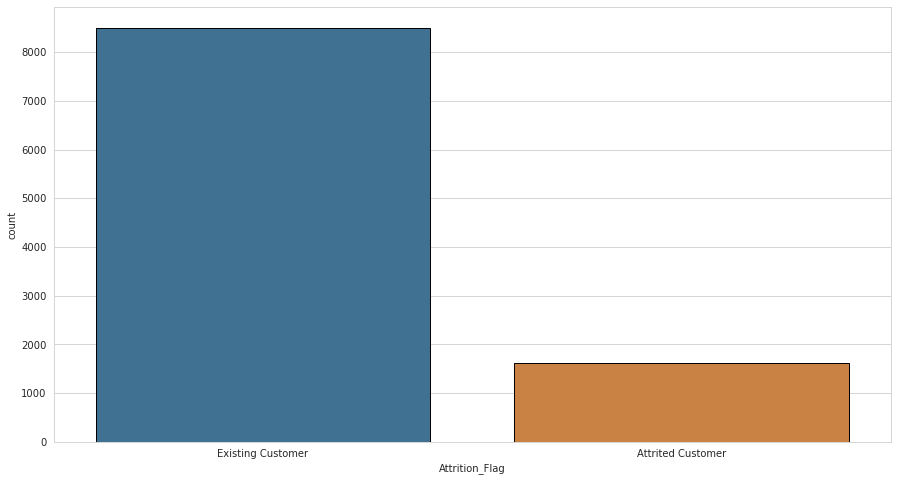

In [8]:
plt.figure(figsize = (15,8))
sns.countplot(x = df['Attrition_Flag'], edgecolor = 'black', saturation = 0.55)
plt.show()

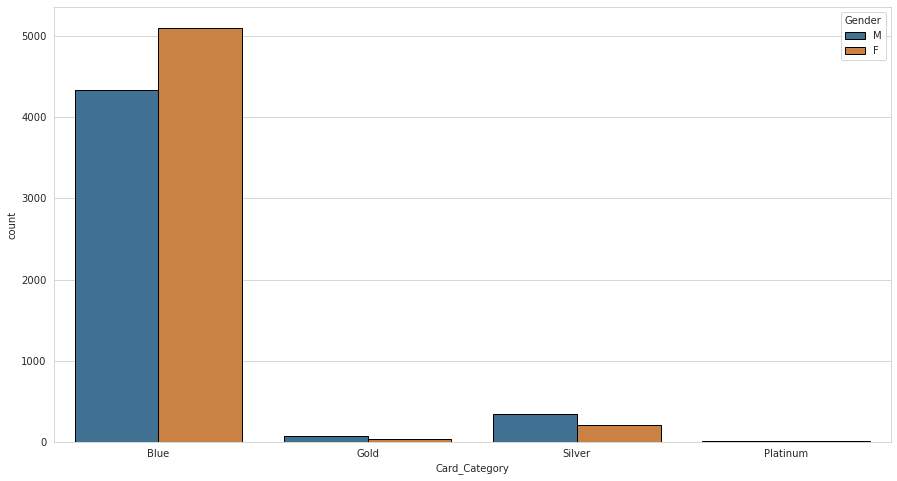

In [9]:
plt.figure(figsize = (15, 8))
sns.countplot(x = df['Card_Category'], hue = df['Gender'], edgecolor = 'black', saturation = 0.55)
plt.show()

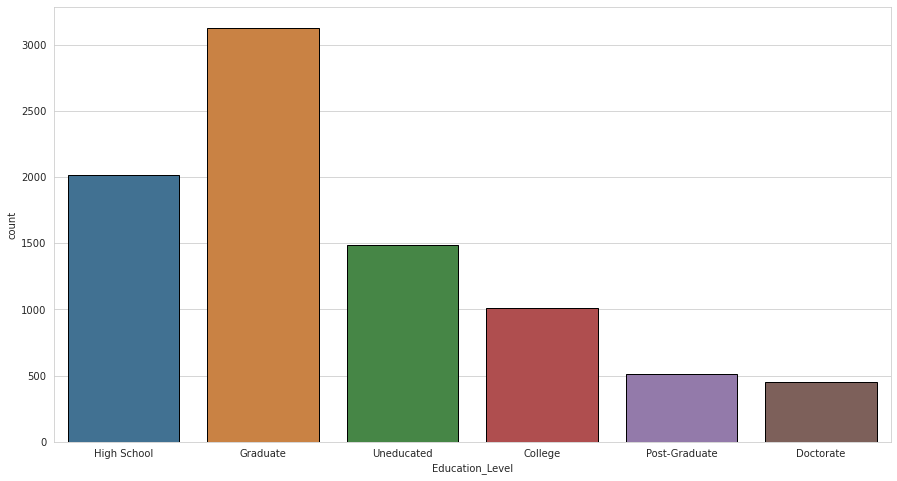

In [10]:
plt.figure(figsize = (15,8))
sns.countplot(x= df['Education_Level'], edgecolor = 'black', saturation = 0.55)
plt.show()

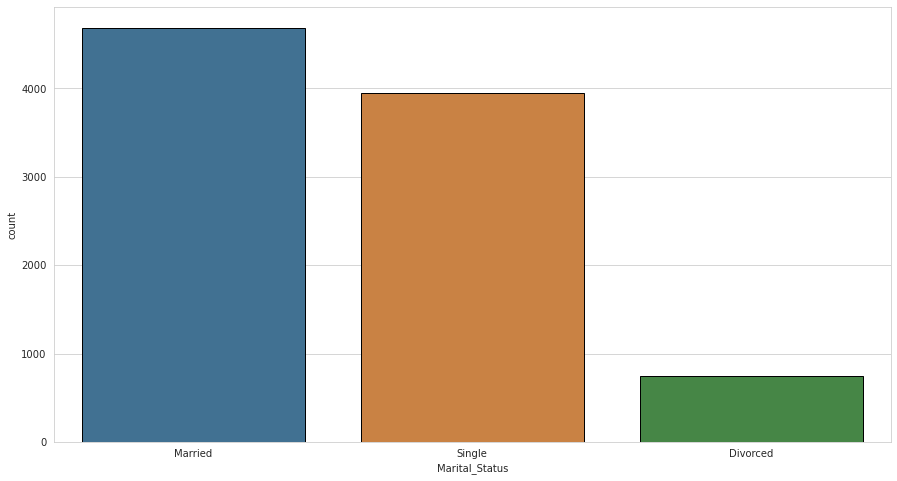

In [11]:
plt.figure(figsize = (15,8))
sns.countplot(x = df['Marital_Status'], edgecolor = 'black', saturation = 0.55)
plt.show()

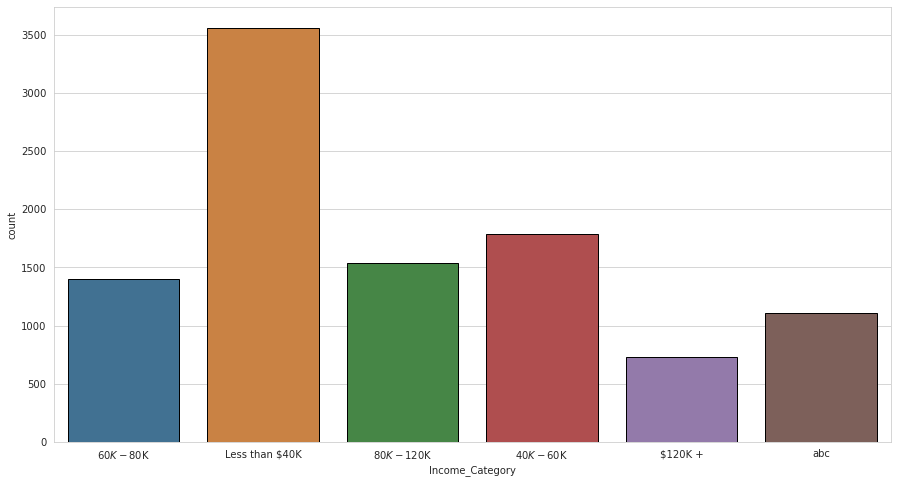

In [12]:
plt.figure(figsize = (15,8))
sns.countplot(x = df['Income_Category'], edgecolor = 'black', saturation = 0.55)
plt.show()

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Missing Values</h1><a id = "3" ></a>

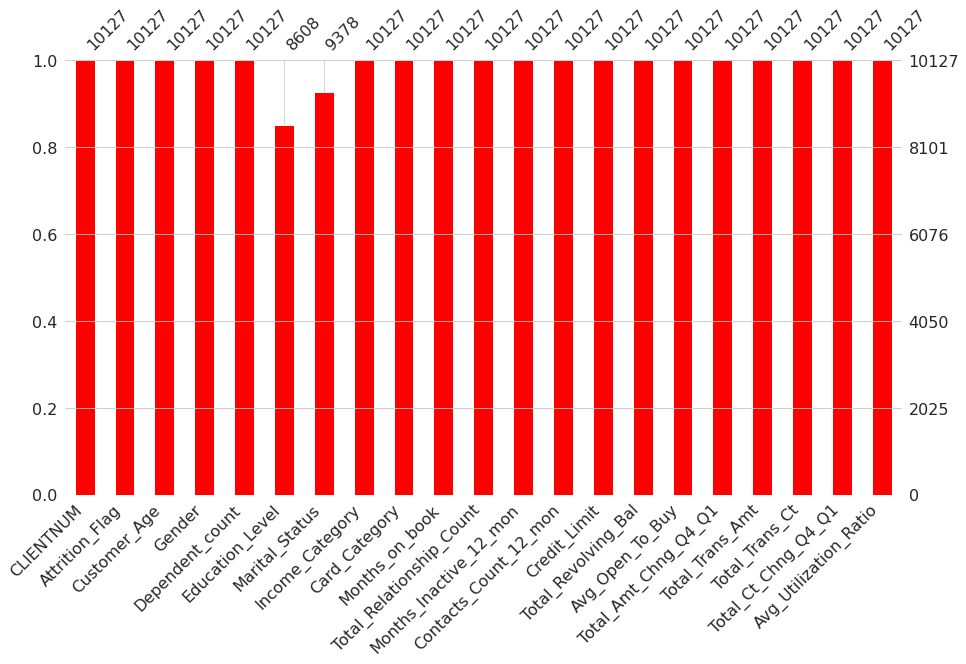

In [13]:
missingno.bar(df, color = 'red', figsize = (15,8))
plt.show()

From above plot we can say this data do not have any missing values but inplace of missing values many attributes have value "Unknown" which is same as missing values. Giving Nan values a seprate class (Unknown) in categorical variables is a great technique to deal with missing values in categorical variables 

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">UNIVARIATE ANALYSIS</h1><a id = "3" ></a>

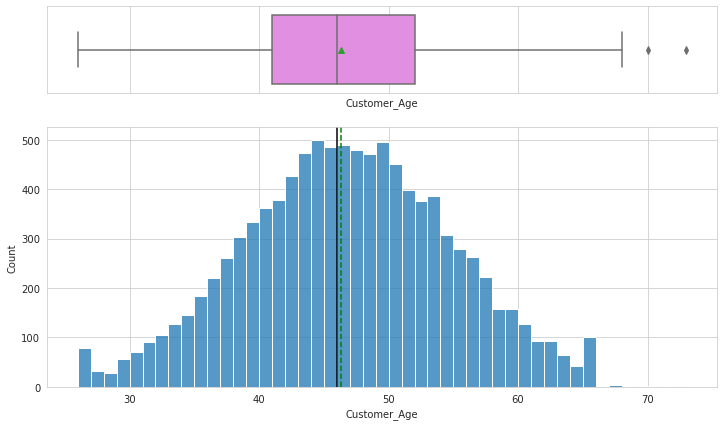

In [14]:
histogram_boxplot(df, "Customer_Age")

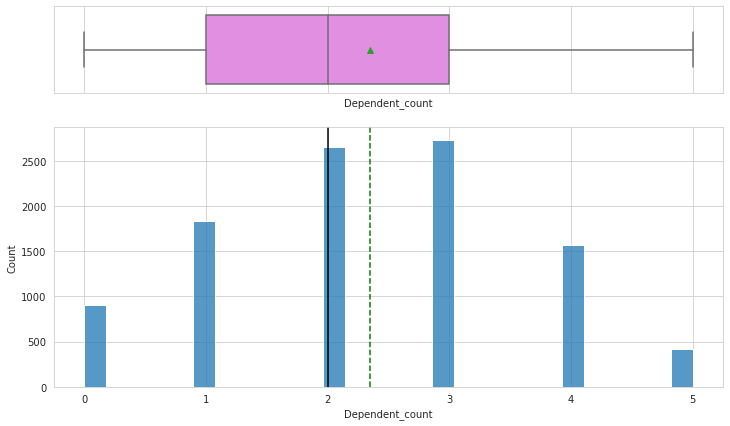

In [15]:
histogram_boxplot(df, "Dependent_count")

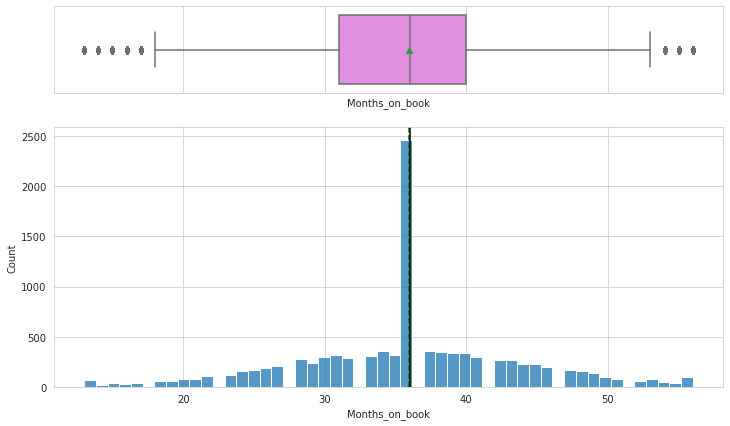

In [16]:
histogram_boxplot(df, "Months_on_book")

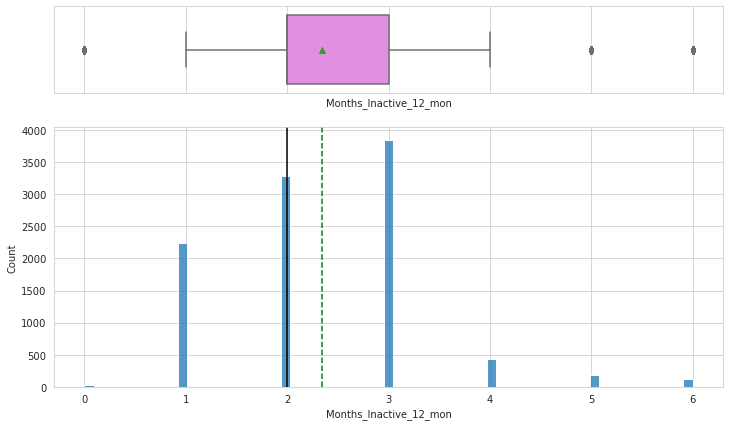

In [17]:
histogram_boxplot (df, "Months_Inactive_12_mon")

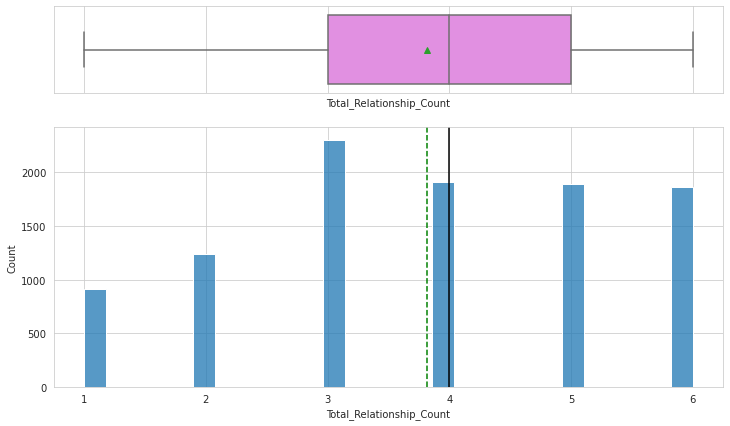

In [18]:
histogram_boxplot (df, "Total_Relationship_Count")

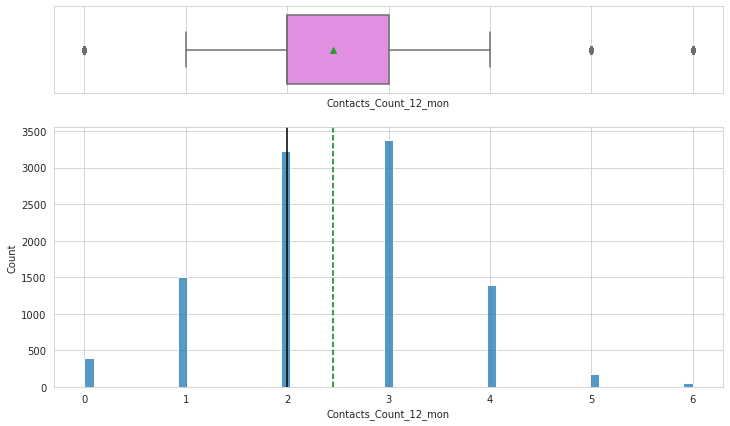

In [19]:
histogram_boxplot (df, "Contacts_Count_12_mon")

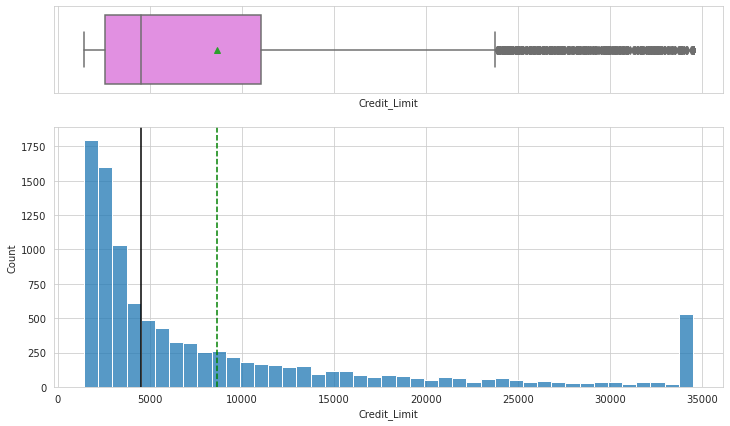

In [20]:
histogram_boxplot (df, "Credit_Limit")

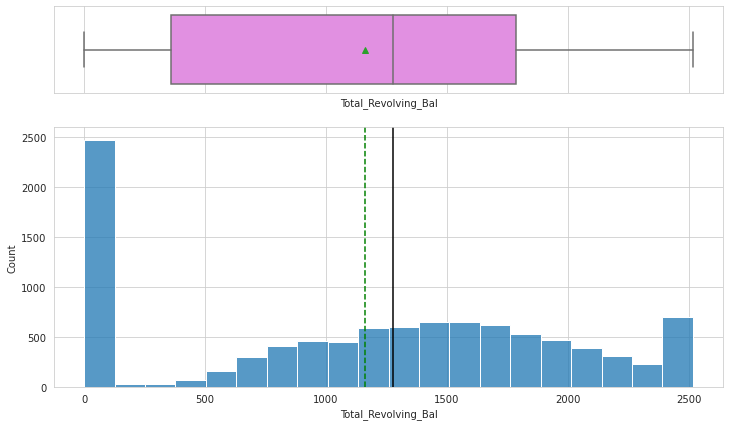

In [21]:
histogram_boxplot (df, "Total_Revolving_Bal")

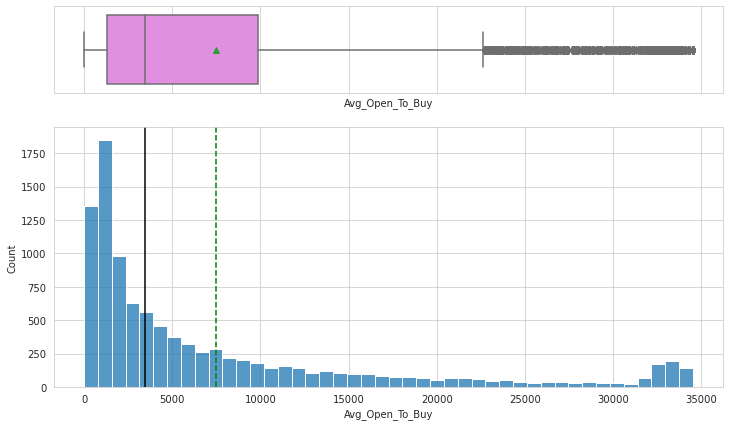

In [22]:
histogram_boxplot (df, "Avg_Open_To_Buy")

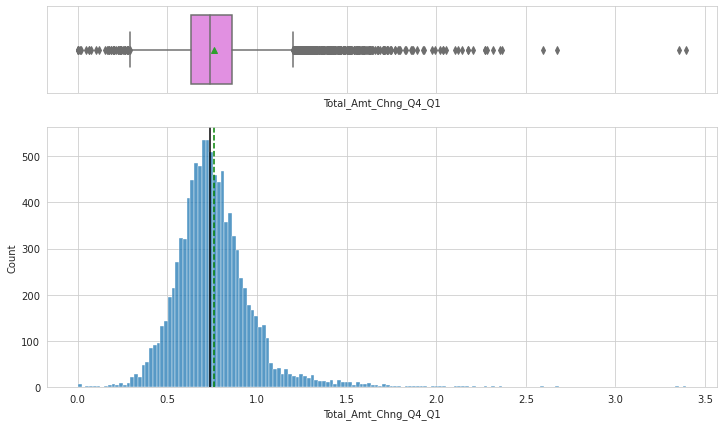

In [23]:
histogram_boxplot (df, "Total_Amt_Chng_Q4_Q1")

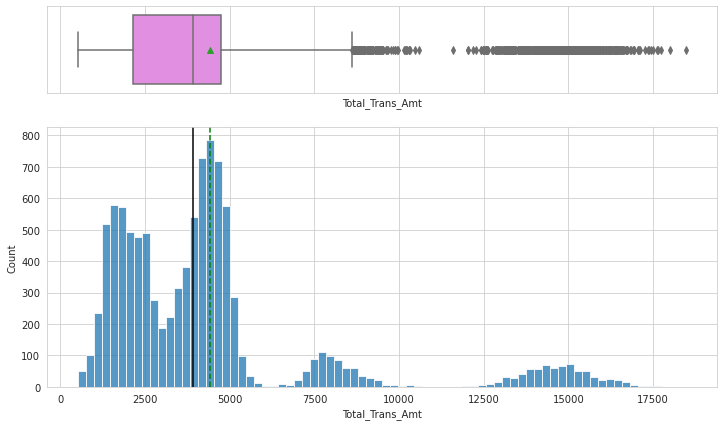

In [24]:
histogram_boxplot (df, "Total_Trans_Amt")

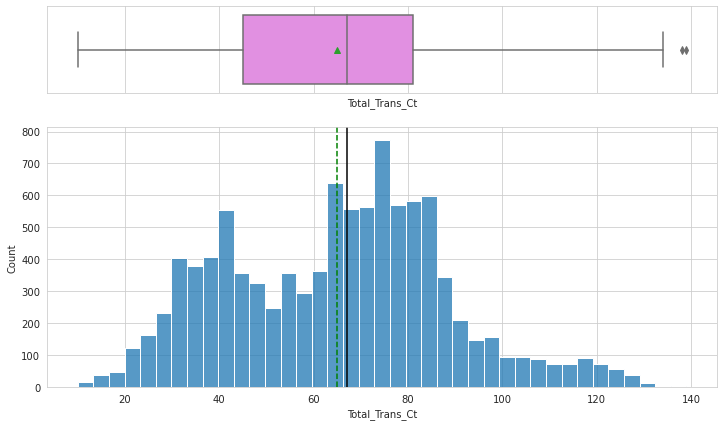

In [25]:
histogram_boxplot (df, "Total_Trans_Ct")

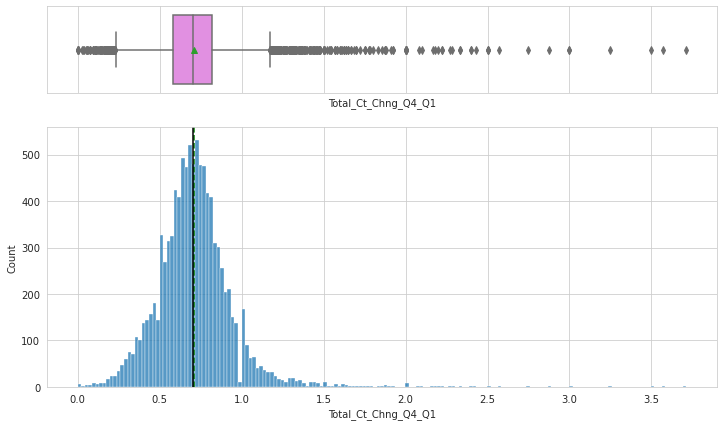

In [26]:
histogram_boxplot (df, "Total_Ct_Chng_Q4_Q1")

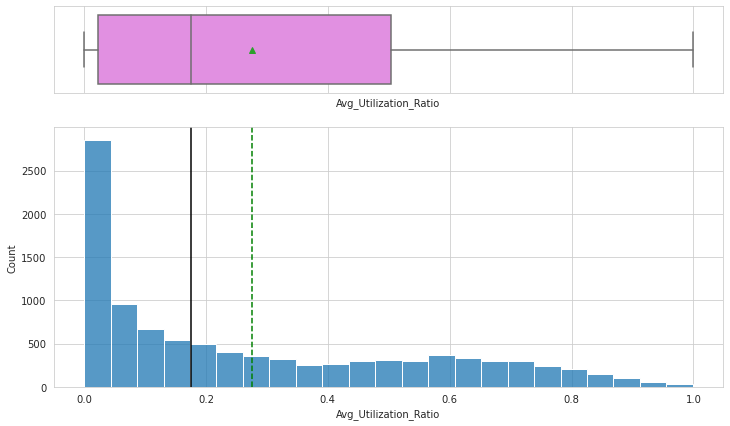

In [27]:
histogram_boxplot (df, "Avg_Utilization_Ratio")

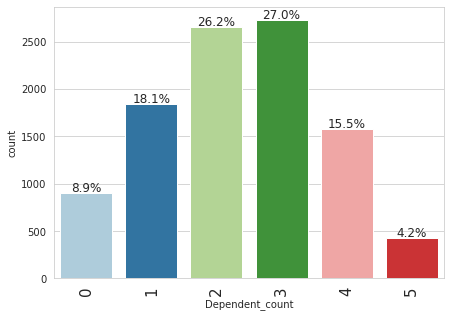

In [28]:
labeled_barplot(df, "Dependent_count", perc=True)

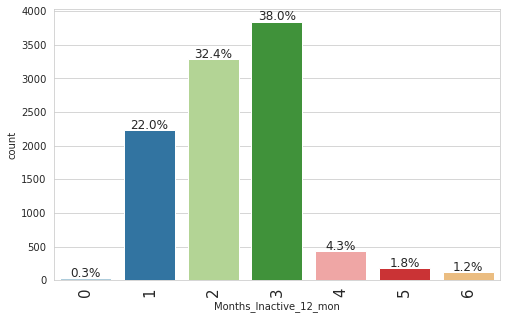

In [29]:
labeled_barplot(df, "Months_Inactive_12_mon", perc=True)

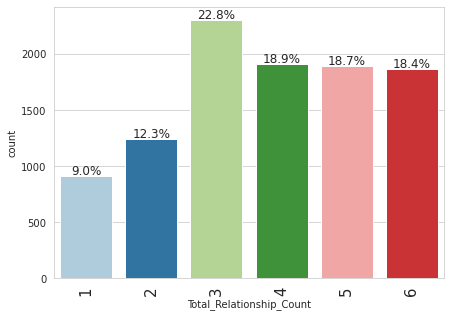

In [30]:
labeled_barplot(df, "Total_Relationship_Count", perc=True)

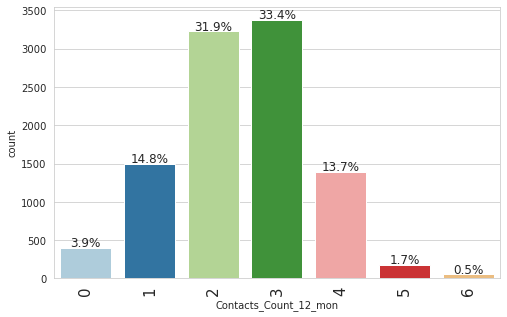

In [31]:
labeled_barplot(df, "Contacts_Count_12_mon", perc=True)

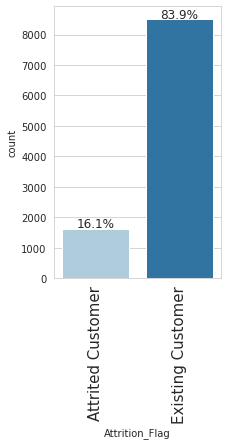

In [32]:
labeled_barplot(df, "Attrition_Flag", perc=True)

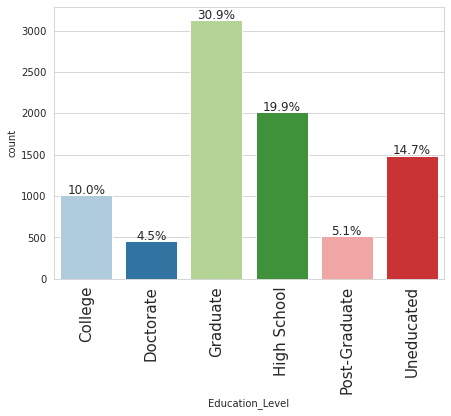

In [33]:
labeled_barplot(df, "Education_Level", perc=True)

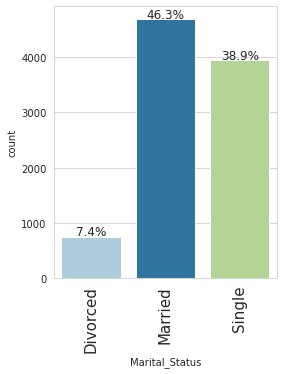

In [34]:
labeled_barplot(df, "Marital_Status", perc=True)

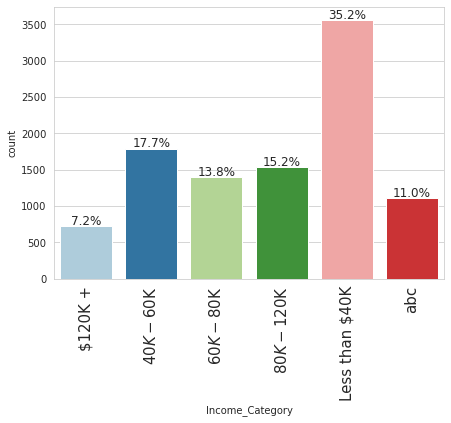

In [35]:
labeled_barplot(df, "Income_Category", perc=True)

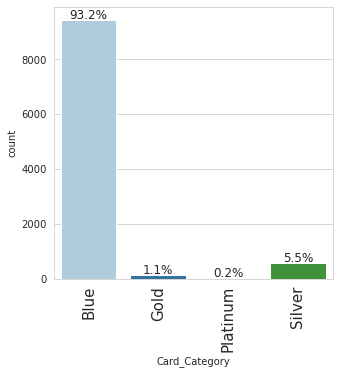

In [36]:
labeled_barplot(df, "Card_Category", perc=True)

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">BIVARIATE ANALYSIS</h1><a id = "3" ></a>

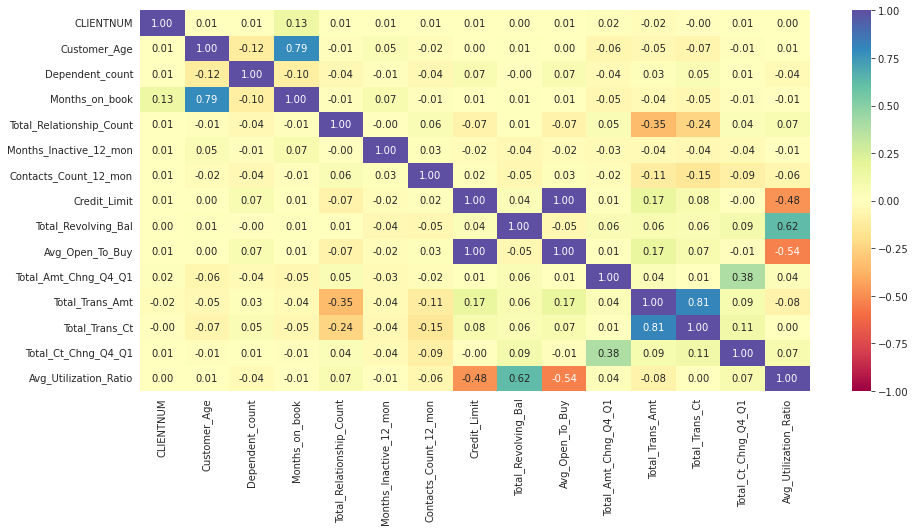

In [37]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Attrition_Flag  Attrited Customer  Existing Customer    All
Gender                                                     
All                          1627               8500  10127
F                             930               4428   5358
M                             697               4072   4769
------------------------------------------------------------------------------------------------------------------------


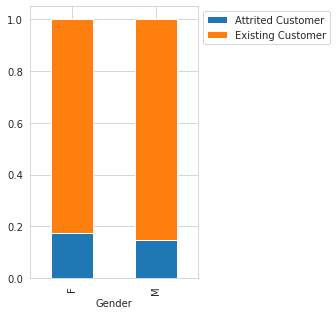

In [38]:
stacked_barplot(df, "Gender", "Attrition_Flag")

Females have slightly higher attrition rate than males but the difference is not remarkable.

Attrition_Flag   Attrited Customer  Existing Customer    All
Dependent_count                                             
All                           1627               8500  10127
3                              482               2250   2732
2                              417               2238   2655
1                              269               1569   1838
4                              260               1314   1574
0                              135                769    904
5                               64                360    424
------------------------------------------------------------------------------------------------------------------------


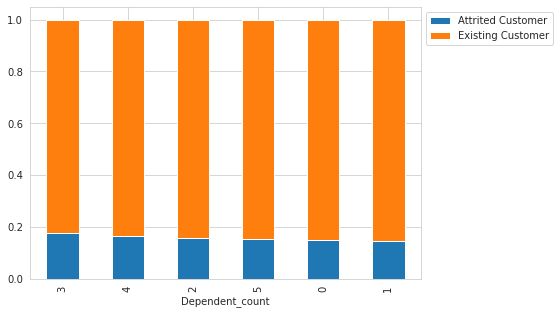

In [39]:
stacked_barplot(df, "Dependent_count", "Attrition_Flag")

No difference in attrition rate based on the count of dependents.

Attrition_Flag   Attrited Customer  Existing Customer   All
Education_Level                                            
All                           1371               7237  8608
Graduate                       487               2641  3128
High School                    306               1707  2013
Uneducated                     237               1250  1487
College                        154                859  1013
Doctorate                       95                356   451
Post-Graduate                   92                424   516
------------------------------------------------------------------------------------------------------------------------


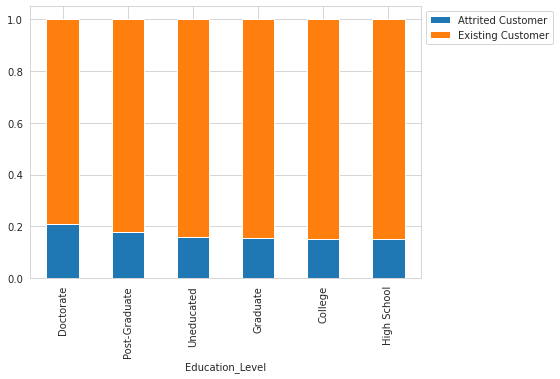

In [40]:
stacked_barplot(df, "Education_Level", "Attrition_Flag")

Attrition rate is slightly highar for those with doctorate degrees and is relatively lower for those with high school, college, graduate degrees, or uneducated customers.  But the difference is not remarkable.

Attrition_Flag  Attrited Customer  Existing Customer   All
Marital_Status                                            
All                          1498               7880  9378
Married                       709               3978  4687
Single                        668               3275  3943
Divorced                      121                627   748
------------------------------------------------------------------------------------------------------------------------


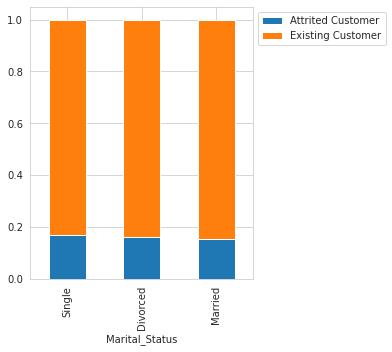

In [41]:
stacked_barplot(df, "Marital_Status", "Attrition_Flag")

No difference in attrition rates based on marital status.

Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
All                           1627               8500  10127
Less than $40K                 612               2949   3561
$40K - $60K                    271               1519   1790
$80K - $120K                   242               1293   1535
$60K - $80K                    189               1213   1402
abc                            187                925   1112
$120K +                        126                601    727
------------------------------------------------------------------------------------------------------------------------


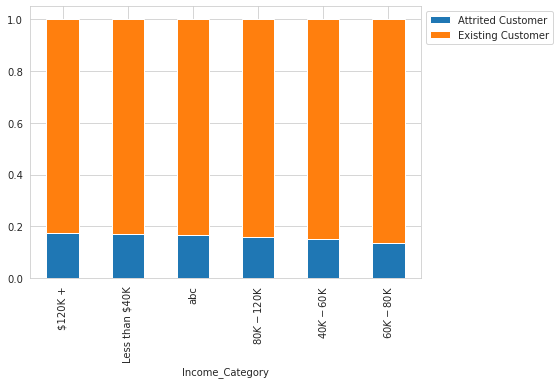

In [42]:
stacked_barplot(df, "Income_Category", "Attrition_Flag")

No major difference in attrition rates for customers from different income categories.

Attrition_Flag  Attrited Customer  Existing Customer    All
Card_Category                                              
All                          1627               8500  10127
Blue                         1519               7917   9436
Silver                         82                473    555
Gold                           21                 95    116
Platinum                        5                 15     20
------------------------------------------------------------------------------------------------------------------------


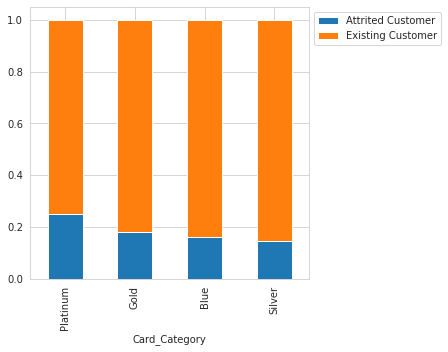

In [43]:
stacked_barplot(df, "Card_Category", "Attrition_Flag")

Attrition rate is a bit higher for those holding Platinum cards compared to other card types.

Attrition_Flag            Attrited Customer  Existing Customer    All
Total_Relationship_Count                                             
All                                    1627               8500  10127
3                                       400               1905   2305
2                                       346                897   1243
1                                       233                677    910
5                                       227               1664   1891
4                                       225               1687   1912
6                                       196               1670   1866
------------------------------------------------------------------------------------------------------------------------


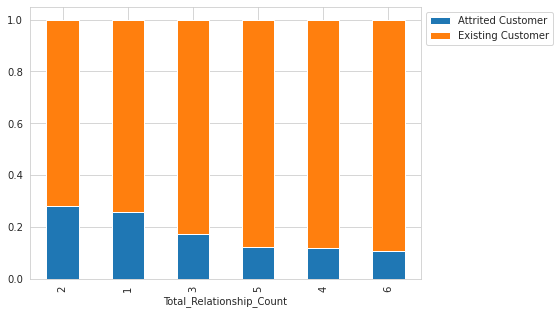

In [44]:
stacked_barplot(df, "Total_Relationship_Count", "Attrition_Flag")

This graph is very helpful!  The attrition rates are visibly a lot higher among those customers that hold lower total number of products.  Those who hold only 1-2 products have the highest attrition rates followed by those that hold 3.  Those who whold 4, 5, or 6 products have the lowest attrition rates and similar attrition rates.

Attrition_Flag          Attrited Customer  Existing Customer    All
Months_Inactive_12_mon                                             
All                                  1627               8500  10127
3                                     826               3020   3846
2                                     505               2777   3282
4                                     130                305    435
1                                     100               2133   2233
5                                      32                146    178
6                                      19                105    124
0                                      15                 14     29
------------------------------------------------------------------------------------------------------------------------


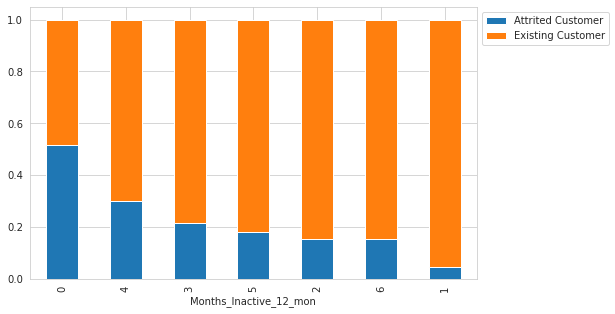

In [45]:
stacked_barplot(df, "Months_Inactive_12_mon", "Attrition_Flag")

This stacked barplot is somewhat bizarre.   Customers with only 1 month of inactivity have the Lowest attrition rate, which makes sense!  However, patients with zero month of inactivity have the highest attrition rate???! Customers with higher number of inactive months also have higher attrition rates, which makes sense.  However, what doesn't fit the pattern is the fact that those customers who are active at all times without any gap inactivity would have 50% attrition rate!  This needs to be looked into further.

Attrition_Flag         Attrited Customer  Existing Customer    All
Contacts_Count_12_mon                                             
All                                 1627               8500  10127
3                                    681               2699   3380
2                                    403               2824   3227
4                                    315               1077   1392
1                                    108               1391   1499
5                                     59                117    176
6                                     54                  0     54
0                                      7                392    399
------------------------------------------------------------------------------------------------------------------------


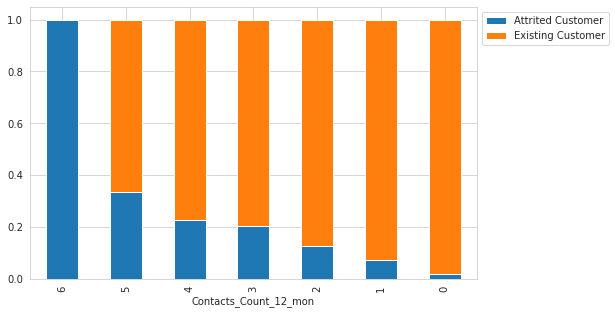

In [46]:
stacked_barplot(df, "Contacts_Count_12_mon", "Attrition_Flag")

There is a helpful patten here!  The higher tha count of contact between the customer and the bank in the last 12 months, the higher the attrition rate!  In fact, those customers with 6 counts of interaction with the bank had a 100% attrition rate while those with 5 counts of interaction with the bank had a 30-35% attrition rate!  Those with 2 interactions had 10% attrition rate!  Those with 0 interactions had attrition rates in low single digits based on the group.  There is a very solid pattern here.  Are the attrition rates higher because the customers are interacting with the bank way too often?  Or are their interactions suggestive of a deeper problem?  Are these interctions associated with poor service and complaints, triggering the calls?  Or are they associated with services that the customers wanted but were dissatisfied with later on due to poor experience with the service?  We are not sure if this is just association, coincidence, or cause/effect relationship.  If it's cause effect relationship, we don't know if more interacion is leading to higher attrition rate or that more interaction is simply a surrogate for an underlying deeper problem due to which customers are interacting more with the bank to have it resolved and then finally quit when they are not happy/satisfied with the service or with resolutions offered (or not offered!).

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">SUMMARY OF EDA</h1><a id = "4" ></a>


The dataset has 10127 rows and 21 columns.

15 variables are numerical, remaining 6 are object types.

2 columns have less than 10127 non-null values i.e. columns have missing values.

Data Cleaning

Drop "CLIENTNUM" as "CLIENTNUM" is unique for each candidate and might not add value to modeling.

Missing value imputation will be done after splitting the data.

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Observations</h1><a id = "4" ></a>

- Customer_Age: It has a normal distribution with outliers (>70).
- Months_on_book: It is a gaussian distribution but has the extreme peak of 36.
- Credit_Limit: It is skewed distribution towards right with a lot of outliers (>25000).
- Total_Revolving_Bal: It has a lot of 0 values and it doesn't show a gaussian distribution.
- Avg_Open_To_Buy: It is skewed distribution towards right with a lot of outliers.
- Total_Amt_Chng_Q4_Q1: It shows a gaussian distribution with outliers.
- Total_Trans_Amt: It doesn't have a normal distribution.
- Total_Trans_Ct: It looks like binomial distribution (with two peaks).
- Total_Ct_Chng_Q4_Q1: It has a gaussian distribution with outliers.
- Avg_Utilization_Ratio: It has skewed distribution towards right.

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Data Preprocessing</h1><a id = "4" ></a>


Data preprocessing involves transforming raw data to well-formed data sets so that data mining analytics can be applied. Raw data is often incomplete and has inconsistent formatting. The adequacy or inadequacy of data preparation has a direct correlation with the success of any project that involve data analyics.

![](https://media.geeksforgeeks.org/wp-content/uploads/20190312184006/Data-Preprocessing.png)  

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Approaching Categorical Features</h1><a id = "4" ></a>

Categorical variables/features are any feature type can be classified into two major
types:
*  Nominal
*  Ordinal

**Nominal variables** are variables that have two or more categories which do not
have any kind of order associated with them. For example, if gender is classified
into two groups, i.e. male and female, it can be considered as a nominal variable.

**Ordinal variables** on the other hand, have “levels” or categories with a particular
order associated with them. For example, an ordinal categorical variable can be a
feature with three different levels: low, medium and high. Order is important.

Ordinal variables in this data are :-

1. Income_Category
2. Card_Category
3. Education_Level

In this notebook i will seprately encode ordinal variables first

In [47]:
Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4,
    'Unknown'        : 5
}


Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
}


Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1
}

Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
}


df.loc[:, 'Income_Category'] = df['Income_Category'].map(Income_Category_map)
df.loc[:, 'Card_Category'] = df['Card_Category'].map(Card_Category_map)
df.loc[:, 'Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
df.loc[:, 'Education_Level'] = df['Education_Level'].map(Education_Level_map)


**Label Encoding** refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.
![](https://ekababisong.org/assets/seminar_IEEE/LabelEncoder.png)  

We can do label Encoding From LabelEncoder of scikit-Learn but to do so first we have to impute missing values in data 

In this Notebook i am going to use scikit-Learn LabelEncoder Due to following reasons

1. Label Encoder encode data on basis of count and this data do not have lots of ordinal features\ 
    
2. To use label encoder first we have to create NULL values as new category and in Our data this task is already done

In [48]:
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()

cat_cols = [x for x in df.columns if df[x].dtype == 'object']

for c in cat_cols:
    df.loc[:, c] = lbe.fit_transform(df.loc[:, c])

In [49]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,1,3,1.0,1,2.0,0,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,0,5,3.0,2,0.0,0,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,1,3,3.0,1,3.0,0,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,0,4,1.0,3,0.0,0,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,1,3,0.0,1,2.0,0,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  int64  
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  int64  
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   float64
 6   Marital_Status            10127 non-null  int64  
 7   Income_Category           9015 non-null   float64
 8   Card_Category             10127 non-null  int64  
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [51]:
df = df.sample(frac = 1).reset_index(drop = True) #To shuffle data

X_columns = df.drop(['Attrition_Flag', 'CLIENTNUM'], axis = 1)
y = df.Attrition_Flag

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Dealing with NaN Values</h1><a id = "5" ></a>

In [52]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imp_mean.fit(X_columns)
X = imp_mean.transform(X_columns)
print(X)

[[49.     1.     2.    ... 64.     0.684  0.36 ]
 [51.     1.     2.    ... 88.     0.66   0.   ]
 [47.     0.     3.    ... 60.     0.875  0.   ]
 ...
 [50.     0.     2.    ... 41.     0.464  0.   ]
 [36.     1.     2.    ... 61.     0.794  0.552]
 [56.     1.     3.    ... 38.     0.31   0.61 ]]


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Evaluation Metrics</h1><a id = "5" ></a>

I think before selecting an optimal model for given data first we have to analayze target feature. Target Feature can be discrete in case of classification problem or continuous in case of Regression Problem

- **[Area under the ROC (Receiver Operating Characteristic) curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)** : AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.


![](https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png?w=576)

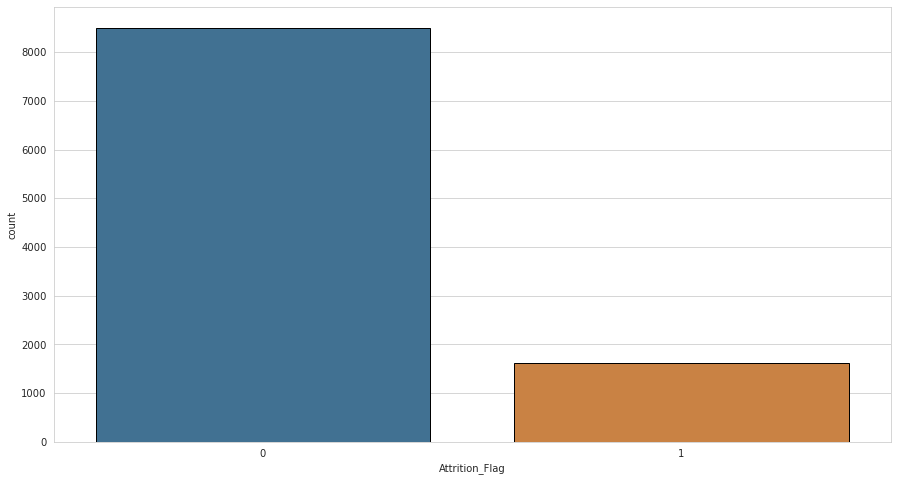

In [53]:
plt.figure(figsize = (15, 8))
sns.countplot(x = y, edgecolor = 'black', saturation = 0.55)
plt.show()

We can see that the target is **skewed** and thus the best metric for this binary classification problem would be Area Under the ROC Curve (AUC). We can use precision and recall too, but AUC combines these two metrics. Thus, we will be using AUC to evaluate the model that we build on this dataset.

In [54]:
def plot_roc_auc_curve(X, y, model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
    
    model.fit(x_train, y_train)
    y_predict = model.predict_proba(x_test)
    y_predict_proba = y_predict[:, 1]
    
    fpr , tpr, _ = roc_curve(y_test, y_predict_proba)
    
    plt.figure(figsize = (15,8))
    plt.plot(fpr, tpr, 'b+', linestyle = '-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr, tpr, alpha = 0.5 )
    auc_score = roc_auc_score(y_test, y_predict_proba)
    plt.title(f'ROC AUC Curve having \n AUC score : {auc_score}')
    

In [55]:
# funtion to plot learning curves

def plot_learning_curve(X, Y, model):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(100,len(x_train),100):
        
        model.fit(x_train.iloc[:m,:], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Models</h1><a id = "6" ></a>

In [56]:
#Cross Validation Score

from sklearn.model_selection import StratifiedKFold

def compute_CV(X, y, model, k):
    
    kf = StratifiedKFold(n_splits = k)
    auc_scores = []
    i = 0
    
    for idx in kf.split(X = X, y = y):
        
        train_idx, val_idx = idx[0], idx[1]
        
        i += 1 
        X_train = X.iloc[train_idx, :]
        y_train = y[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        y_predict = model.predict_proba(X_val)
        y_predict_prob = y_predict[:,1]
        
        auc_score = roc_auc_score(y_val, y_predict_prob)
        print(f'AUC Score of {i} Fold is : {auc_score}')
        auc_scores.append(auc_score)
    print('-----------------------------------------------')
    print(f'Average AUC Score of {k} Folds is : {np.mean(auc_scores)}')
    

**1. [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20statistical,a%20form%20of%20binary%20regression)** is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).



![](https://i.stack.imgur.com/bQVzF.png)

In [57]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

X_std = pd.DataFrame(X, columns = X_columns.columns)

clf1 = LogisticRegression()

compute_CV(X_std, y, clf1, 5)

AUC Score of 1 Fold is : 0.9064146517502706
AUC Score of 2 Fold is : 0.8722374594009383
AUC Score of 3 Fold is : 0.8670371040723983
AUC Score of 4 Fold is : 0.8858135746606334
AUC Score of 5 Fold is : 0.8986063348416289
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.8860218249451739


**2. [Support Vector Machine (SVM)](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)** : The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.



![](https://static.javatpoint.com/tutorial/machine-learning/images/support-vector-machine-algorithm.png)


In [58]:
#SVM

from sklearn.svm import SVC

clf2 = SVC(probability = True, C = 100, kernel = 'rbf')

compute_CV(X_std, y, clf2, 5)

AUC Score of 1 Fold is : 0.8827914110429448
AUC Score of 2 Fold is : 0.8626705160591844
AUC Score of 3 Fold is : 0.8624036199095022
AUC Score of 4 Fold is : 0.8597285067873304
AUC Score of 5 Fold is : 0.8683619909502263
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.8671912089498376


**3. Decision Tree:** A decision tree is a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks. It has a hierarchical, tree structure, which consists of a root node, branches, internal nodes and leaf nodes.

![](https://miro.medium.com/max/688/1*bcLAJfWN2GpVQNTVOCrrvw.png)

In [59]:
#Decision Tree

clf3 = DecisionTreeClassifier(criterion='entropy')

compute_CV(X_std, y, clf3, 5)

AUC Score of 1 Fold is : 0.8775333814507399
AUC Score of 2 Fold is : 0.893563695416817
AUC Score of 3 Fold is : 0.8878506787330317
AUC Score of 4 Fold is : 0.8980316742081449
AUC Score of 5 Fold is : 0.8965610859728508
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.890708103156317


**4. [Random Forest Classifier](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)** : Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)


In [60]:
#Random Forest Model


clf4 = RandomForestClassifier(n_estimators=70, max_features=70,bootstrap=False,n_jobs=2,criterion='entropy',random_state=123)

compute_CV(X_std, y, clf4, 5)

AUC Score of 1 Fold is : 0.9116257668711657
AUC Score of 2 Fold is : 0.9166420064958499
AUC Score of 3 Fold is : 0.9121058823529412
AUC Score of 4 Fold is : 0.919897737556561
AUC Score of 5 Fold is : 0.9282588235294118
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.917706043361186


**5. Bagging** : In parallel methods we fit the different considered learners independently from each others and, so, it is possible to train them concurrently. The most famous such approach is “bagging” (standing for “bootstrap aggregating”) that aims at producing an ensemble model that is more robust than the individual models composing it.

![](https://dataaspirant.com/wp-content/uploads/2020/09/5-Bagging-ensemble-method.png)

In [70]:
#Bagging 

clf5 = BaggingClassifier(KNeighborsClassifier(), max_samples=0.6, max_features=0.4, warm_start=True)

compute_CV(X_std, y, clf4, 5)

AUC Score of 1 Fold is : 0.9046675624564547
AUC Score of 2 Fold is : 0.9610470057097331
AUC Score of 3 Fold is : 0.9558677466471915
AUC Score of 4 Fold is : 0.962914619572434
AUC Score of 5 Fold is : 0.9647822334351347
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9498558335641896


**6. Gradient Boost** : Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

![](https://www.researchgate.net/publication/351542039/figure/fig1/AS:1022852723662850@1620878501807/Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png)

In [62]:
# Gradient Boost

clf6 = GradientBoostingClassifier(n_estimators=70, max_depth=12,min_samples_leaf=2)

compute_CV(X_std, y, clf6, 5)

AUC Score of 1 Fold is : 0.9843576326236017
AUC Score of 2 Fold is : 0.987843738722483
AUC Score of 3 Fold is : 0.9825900452488687
AUC Score of 4 Fold is : 0.9888542986425339
AUC Score of 5 Fold is : 0.9833104072398191
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9853912244954612


**7. Adaboost** : AdaBoost Algorithm is also known as Adaptive Boosting is an Ensemble modelling technique used in Machine Learning to find the best model.

![](https://i.ytimg.com/vi/BoGNyWW9-mE/maxresdefault.jpg)

In [63]:
#Adaboost

clf7 = AdaBoostClassifier(n_estimators=60)

compute_CV(X_std, y, clf7, 5)

AUC Score of 1 Fold is : 0.9859473114399134
AUC Score of 2 Fold is : 0.9845633345362685
AUC Score of 3 Fold is : 0.9867438914027149
AUC Score of 4 Fold is : 0.9776262443438913
AUC Score of 5 Fold is : 0.9870244343891403
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9843810432223856


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Oversampling With ADASYN</h1><a id = "7" ></a>

In [64]:
# oversampling
oversampling = ADASYN(
    sampling_strategy='auto', # samples only the minority class
        random_state=0,
        n_neighbors=5,
        n_jobs=1)

X_oversampled, y_oversampled = oversampling.fit_resample(X, y)

In [65]:
# new resampled X_train and y_train
X_oversampled.shape, y_oversampled.shape

((17361, 19), (17361,))

In [66]:
print(X_oversampled)

[[49.          1.          2.         ... 64.          0.684
   0.36      ]
 [51.          1.          2.         ... 88.          0.66
   0.        ]
 [47.          0.          3.         ... 60.          0.875
   0.        ]
 ...
 [48.01996075  0.          2.99001962 ... 57.8303336   0.70358475
   0.        ]
 [49.23110283  0.          2.76889717 ... 42.53779434  0.5193606
   0.        ]
 [45.239955    0.          2.52889389 ... 46.28893889  0.6200237
   0.        ]]


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Models on Oversampled Data</h1><a id = "7" ></a>

In [67]:
#Cross Validation Score

from sklearn.model_selection import StratifiedKFold

def compute_CV(X, y, model, k):
    
    kf = StratifiedKFold(n_splits = k)
    auc_scores = []
    i = 0
    
    for idx in kf.split(X = X, y = y):
        
        train_idx, val_idx = idx[0], idx[1]
        
        i += 1 
        X_train = X.iloc[train_idx, :]
        y_train = y[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        y_predict = model.predict_proba(X_val)
        y_predict_prob = y_predict[:,1]
        
        auc_score = roc_auc_score(y_val, y_predict_prob)
        print(f'AUC Score of {i} Fold is : {auc_score}')
        auc_scores.append(auc_score)
    print('-----------------------------------------------')
    print(f'Average AUC Score of {k} Folds is : {np.mean(auc_scores)}')

In [68]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression


X_std = pd.DataFrame(X_oversampled, columns = X_columns.columns)

clf1 = LogisticRegression()

compute_CV(X_std, y_oversampled, clf1, 5)

AUC Score of 1 Fold is : 0.8932560299923692
AUC Score of 2 Fold is : 0.8959460894967468
AUC Score of 3 Fold is : 0.9062584650112867
AUC Score of 4 Fold is : 0.8983299030673217
AUC Score of 5 Fold is : 0.9061741468596469
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.8999929268854743


In [69]:
#SVM

from sklearn.svm import SVC

clf2 = SVC(probability = True, C = 100, kernel = 'rbf')

compute_CV(X_std, y_oversampled, clf2, 5)

AUC Score of 1 Fold is : 0.8723001891111775
AUC Score of 2 Fold is : 0.8407739676005841
AUC Score of 3 Fold is : 0.8208377041561545
AUC Score of 4 Fold is : 0.8514320807329704
AUC Score of 5 Fold is : 0.824943898552649
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.8420575680307072


In [70]:
#Decision Tree

clf3 = DecisionTreeClassifier(criterion='entropy')

compute_CV(X_std, y_oversampled, clf3, 5)

AUC Score of 1 Fold is : 0.9046675624564547
AUC Score of 2 Fold is : 0.9610470057097331
AUC Score of 3 Fold is : 0.9558677466471915
AUC Score of 4 Fold is : 0.962914619572434
AUC Score of 5 Fold is : 0.9647822334351347
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9498558335641896


In [71]:
#Random Forest Model

clf4 = RandomForestClassifier(n_estimators=70, max_features=70,bootstrap=False,n_jobs=2,criterion='entropy',random_state=123)

compute_CV(X_std, y_oversampled, clf4, 5)

AUC Score of 1 Fold is : 0.9298273116353141
AUC Score of 2 Fold is : 0.9701334484132254
AUC Score of 3 Fold is : 0.9689295910237683
AUC Score of 4 Fold is : 0.9733290731642545
AUC Score of 5 Fold is : 0.9716792258664187
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9627797300205962


In [70]:
#Bagging 

clf5 = BaggingClassifier(KNeighborsClassifier(), max_samples=0.6, max_features=0.4, warm_start=True)

compute_CV(X_std, y_oversampled, clf4, 5)

AUC Score of 1 Fold is : 0.9046675624564547
AUC Score of 2 Fold is : 0.9610470057097331
AUC Score of 3 Fold is : 0.9558677466471915
AUC Score of 4 Fold is : 0.962914619572434
AUC Score of 5 Fold is : 0.9647822334351347
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9498558335641896


In [73]:
# Gradient Boost

clf6 = GradientBoostingClassifier(n_estimators=70, max_depth=12,min_samples_leaf=2)

compute_CV(X_std, y_oversampled, clf6, 5)

AUC Score of 1 Fold is : 0.9846496466606947
AUC Score of 2 Fold is : 0.9985715708405258
AUC Score of 3 Fold is : 0.9976434072500332
AUC Score of 4 Fold is : 0.9984205284822733
AUC Score of 5 Fold is : 0.9989317487717434
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.995643380401054


In [74]:
#Adaboost

clf7 = AdaBoostClassifier(n_estimators=60)

compute_CV(X_std, y_oversampled, clf7, 5)

AUC Score of 1 Fold is : 0.9686362429912745
AUC Score of 2 Fold is : 0.9962734032664985
AUC Score of 3 Fold is : 0.996989941574824
AUC Score of 4 Fold is : 0.9976205019253751
AUC Score of 5 Fold is : 0.9976875580932149
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9914415295702375


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Undersampling</h1><a id = "7" ></a>

In [78]:
undersample = RandomUnderSampler(sampling_strategy='auto')

# fit and apply the transform
X_undersampled, y_undersampled = undersample.fit_resample(X, y)

In [79]:
X_undersampled.shape, y_undersampled.shape

((3254, 19), (3254,))

In [80]:
# summarize class distribution
print(X_undersampled)

[[41.     1.     2.    ... 75.     0.596  0.309]
 [34.     0.     3.    ... 54.     0.8    0.589]
 [48.     1.     2.    ... 78.     0.66   0.   ]
 ...
 [37.     0.     4.    ... 41.     0.414  0.   ]
 [51.     0.     3.    ... 31.     0.409  0.   ]
 [50.     0.     2.    ... 41.     0.464  0.   ]]


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Models on Undersampled Data</h1><a id = "7" ></a>

In [81]:
#Cross Validation Score

from sklearn.model_selection import StratifiedKFold

def compute_CV(X, y, model, k):
    
    kf = StratifiedKFold(n_splits = k)
    auc_scores = []
    i = 0
    
    for idx in kf.split(X = X, y = y):
        
        train_idx, val_idx = idx[0], idx[1]
        
        i += 1 
        X_train = X.iloc[train_idx, :]
        y_train = y[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        y_predict = model.predict_proba(X_val)
        y_predict_prob = y_predict[:,1]
        
        auc_score = roc_auc_score(y_val, y_predict_prob)
        print(f'AUC Score of {i} Fold is : {auc_score}')
        auc_scores.append(auc_score)
    print('-----------------------------------------------')
    print(f'Average AUC Score of {k} Folds is : {np.mean(auc_scores)}')

In [82]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression


X_std = pd.DataFrame(X_undersampled, columns = X_columns.columns)

clf1 = LogisticRegression()

compute_CV(X_std, y_undersampled, clf1, 5)

AUC Score of 1 Fold is : 0.8876923076923078
AUC Score of 2 Fold is : 0.8999339310995753
AUC Score of 3 Fold is : 0.8801793298725814
AUC Score of 4 Fold is : 0.9029164700330344
AUC Score of 5 Fold is : 0.9082508875739644
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.8957945852542928


In [83]:
#SVM

from sklearn.svm import SVC

clf2 = SVC(probability = True, C = 100, kernel = 'rbf')

compute_CV(X_std, y_undersampled, clf2, 5)

AUC Score of 1 Fold is : 0.8427088249174137
AUC Score of 2 Fold is : 0.8733789523360075
AUC Score of 3 Fold is : 0.8413166588013213
AUC Score of 4 Fold is : 0.8596271826333175
AUC Score of 5 Fold is : 0.8418319526627219
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.8517727142701563


In [139]:
#Decision Tree

clf3 = DecisionTreeClassifier(criterion='entropy')

compute_CV(X_std, y_undersampled, clf3, 5)

AUC Score of 1 Fold is : 0.9078338839075035
AUC Score of 2 Fold is : 0.9062812647475224
AUC Score of 3 Fold is : 0.912444549315715
AUC Score of 4 Fold is : 0.8970504955167532
AUC Score of 5 Fold is : 0.8892307692307692
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9025681925436526


In [85]:
#Random Forest Model

#USed as a magic number; when debugging for speed
SILLY_NUMBER = 70

clf4 = RandomForestClassifier(n_estimators=int(SILLY_NUMBER*1.5), max_features=SILLY_NUMBER,bootstrap=False,n_jobs=2,criterion='entropy',random_state=123)

compute_CV(X_std, y_undersampled, clf4, 5)

AUC Score of 1 Fold is : 0.919103350637093
AUC Score of 2 Fold is : 0.9344926852288815
AUC Score of 3 Fold is : 0.9301321378008494
AUC Score of 4 Fold is : 0.9162576687116565
AUC Score of 5 Fold is : 0.9102153846153845
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.922040245398773


In [70]:
#Bagging 

clf5 = BaggingClassifier(KNeighborsClassifier(), max_samples=0.6, max_features=0.4, warm_start=True)

compute_CV(X_std, y_undersampled, clf4, 5)

AUC Score of 1 Fold is : 0.9046675624564547
AUC Score of 2 Fold is : 0.9610470057097331
AUC Score of 3 Fold is : 0.9558677466471915
AUC Score of 4 Fold is : 0.962914619572434
AUC Score of 5 Fold is : 0.9647822334351347
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9498558335641896


In [87]:
# Gradient Boost

SILLY_NUMBER = 70

clf6 = GradientBoostingClassifier(n_estimators=SILLY_NUMBER, max_depth=12,min_samples_leaf=2)

compute_CV(X_std, y_undersampled, clf6, 5)

AUC Score of 1 Fold is : 0.9777725342142519
AUC Score of 2 Fold is : 0.9771118452100047
AUC Score of 3 Fold is : 0.9863803680981595
AUC Score of 4 Fold is : 0.9798489853704577
AUC Score of 5 Fold is : 0.9793988165680473
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9801025098921843


In [88]:
#Adaboost

clf7 = AdaBoostClassifier(n_estimators=60)

compute_CV(X_std, y_undersampled, clf7, 5)

AUC Score of 1 Fold is : 0.9826993865030675
AUC Score of 2 Fold is : 0.9854742803209061
AUC Score of 3 Fold is : 0.9848607833883908
AUC Score of 4 Fold is : 0.9854270882491742
AUC Score of 5 Fold is : 0.9703100591715976
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.9817543195266273


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Hyperparameter Tunning</h1><a id = "7" ></a>

The parameters that the model has here are known as hyper-parameters, i.e. the parameters that control the training/fitting process of the model.

Let’s say there are three parameters a, b, c in the model, and
all these parameters can be integers between 1 and 10. A “correct” combination of
these parameters will provide you with the best result. So, it’s kind of like a suitcase
with a 3-dial combination lock. However, in 3 dial combination lock has only one
correct answer. The model has many right answers. So, how would you find the
best parameters? A method would be to evaluate all the combinations and see which
one improves the metric. We go through all the parameters from 1 to 10. So, we have a
total of 1000 (10 x 10 x 10) fits for the model. Well, that might be expensive because
the model can take a long time to train. Let's visit some efficient methods

* [Random Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) : Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.
   
   
* [Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) : Define a search space as a grid of hyperparameter values and evaluate every position in the grid.


In this notebook i am using **Bayesian optimization with gaussian process**

[Hyperparameter Tuning With Bayesian Optimization](https://machinelearningmastery.com/what-is-bayesian-optimization/)



Bayesian optimization algorithm need a function they can optimize. Most of the time, it’s about the minimization of this function, like we minimize loss.


In [89]:
def optimize(params, param_names, x, y, model):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    
    if model == 'rf':
        clf = RandomForestClassifier(**params)
    
    elif model == 'xgb':
        clf = XGBClassifier(tree_method = 'hist', **params)
       
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]


        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)
    
    

So, let’s say, you want to find the best parameters for best accuracy and obviously, the more the accuracy is better. Now we cannot minimize the accuracy, but we can minimize it when we multiply it by -1. This way, we are minimizing the negative of accuracy, but in fact, we are maximizing accuracy. Using Bayesian optimization with gaussian process can be accomplished by using [gp_minimize function from scikit-optimize (skopt) library](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html). Let’s take a look at how we can tune the parameters of our xgboost model using this
function.

In [159]:
#define a parameter space

param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Integer(5,25, name = 'max_depth')
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators', 'max_depth']


# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = y, model = 'rf')

**[Extreme Gradient Boosting (XGBoost)](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/)** : xgboost is short for eXtreme Gradient Boosting package. It is an efficient and scalable implementation of gradient boosting framework by (Friedman, 2001) (Friedman et al., 2000). The package includes efficient linear model solver and tree learning algorithm. It supports various objective functions, including regression, classification and ranking. The package is made to be extendible, so that users are also allowed to define their own objectives easily.

![](https://miro.medium.com/max/777/1*l4PN8hyAO4fMLxUbIxcETA.png)

In [135]:
#define a parameter space

param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Real(0.01,100, name = 'min_child_weight'),
                space.Real(0.01,1000, name = 'gamma'),
                space.Real(0.1, 1, prior = 'uniform', name = 'colsample_bytree'),
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators' ,'min_child_weight', 'gamma', 'colsample_bytree']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X_columns, y = df.Attrition_Flag, model = 'xgb')

In [136]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 10, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 1589, 'min_child_weight': 82.8589498155077, 'gamma': 120.65456174336059, 'colsample_bytree': 0.9355338951289175}
AUC score of test 0 f 0.9406189101407435
Current parameters of fold number 1 -> {'n_estimators': 1589, 'min_child_weight': 82.8589498155077, 'gamma': 120.65456174336059, 'colsample_bytree': 0.9355338951289175}
AUC score of test 1 f 0.9475604474918804
Current parameters of fold number 2 -> {'n_estimators': 1589, 'min_child_weight': 82.8589498155077, 'gamma': 120.65456174336059, 'colsample_bytree': 0.9355338951289175}
AUC score of test 2 f 0.9492253393665158
Current parameters of fold number 3 -> {'n_estimators': 1589, 'min_child_weight': 82.8589498155077, 'gamma': 120.65456174336059, 'colsample_bytree': 0.9355338951289175}
AUC score of test 3 f 0.9414959276018099
Current parameters of fold number 4 -> {'n_estimators': 1589, 'min_child_weight': 82.8589498155077

Current parameters of fold number 3 -> {'n_estimators': 2000, 'min_child_weight': 100.0, 'gamma': 0.01, 'colsample_bytree': 0.1}
AUC score of test 3 f 0.9718932126696832
Current parameters of fold number 4 -> {'n_estimators': 2000, 'min_child_weight': 100.0, 'gamma': 0.01, 'colsample_bytree': 0.1}
AUC score of test 4 f 0.9700343891402715
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 34.2912
Function value obtained: -0.9695
Current minimum: -0.9809
Iteration No: 8 started. Searching for the next optimal point.
Current parameters of fold number 0 -> {'n_estimators': 100, 'min_child_weight': 96.93571744261676, 'gamma': 0.01, 'colsample_bytree': 1.0}
AUC score of test 0 f 0.9790075784915192
Current parameters of fold number 1 -> {'n_estimators': 100, 'min_child_weight': 96.93571744261676, 'gamma': 0.01, 'colsample_bytree': 1.0}
AUC score of test 1 f 0.9766943341753879
Current parameters of fold number 2 -> {'n_estimators': 100, 'min_child_weight': 96.935717

In [137]:
best_params_xgb = dict(zip(param_names, result.x))
print(f"Best Parameters for XGBClassifier are : {best_params_xgb}")
print(f"Best AUC score {result.fun}")

Best Parameters for XGBClassifier are : {'n_estimators': 2000, 'min_child_weight': 0.01, 'gamma': 0.01, 'colsample_bytree': 1.0}
Best AUC score -0.993484011881298


In [141]:
#XGboost
clf4 = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', **best_params_xgb)

compute_CV(X_columns, df.Attrition_Flag, clf4, 5)

AUC Score of 1 Fold is : 0.9917448574521832
AUC Score of 2 Fold is : 0.9938108985925659
AUC Score of 3 Fold is : 0.9923511312217195
AUC Score of 4 Fold is : 0.9935058823529411
AUC Score of 5 Fold is : 0.99609592760181
-----------------------------------------------
Average AUC Score of 5 Folds is : 0.993501739444244


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Voting Classifier</h1><a id = "8" ></a>

A collection of several models working together on a single set is called an ensemble. The method is called Ensemble Learning. It is much more useful use all different models rather than any one.

![](https://miro.medium.com/max/891/1*I7NsQXwyR36XK62s1iDNzQ.png)

Voting is one of the simplest way of combining the predictions from multiple machine learning algorithms. Voting classifier isn’t an actual classifier but a wrapper for set of different ones that are trained and valuated in parallel in order to exploit the different peculiarities of each algorithm.


In [98]:
#Voting Classifier

from sklearn.ensemble import VotingClassifier

clf5 = VotingClassifier(
               estimators = [('lr', clf1), ('svm', clf2), ('rf', clf3), ('xgb', clf4)],
               voting = 'soft')

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms (That's why I used 4 different classifiers). This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

There is a hyperparameter voting in VotingClassifier we can set it hard or soft 

In hard voting, the VotingClassifier counts the number of each Class instance and then assigns to a test instance a class that was voted by majority of the classifiers.

If all classifiers in VotingClassifier are able to estimate class probabilities (i.e., they have a predict_proba() method), then we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All we need to do is to set voting="soft" and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so we need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).

In [100]:
compute_CV(X_std, y_undersampled, clf5, 6)

AUC Score of 1 Fold is : 0.9391415237681788
AUC Score of 2 Fold is : 0.9691637725200781
AUC Score of 3 Fold is : 0.9553246823981155
AUC Score of 4 Fold is : 0.9691725330537437
AUC Score of 5 Fold is : 0.9614384335725277
AUC Score of 6 Fold is : 0.953323075666181
-----------------------------------------------
Average AUC Score of 6 Folds is : 0.9579273368298041


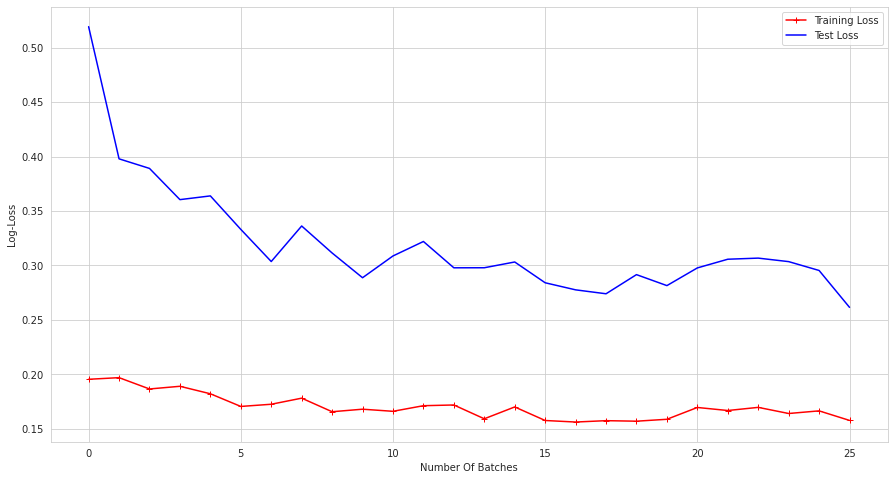

In [102]:
plot_learning_curve(X_std, y_undersampled, clf5)

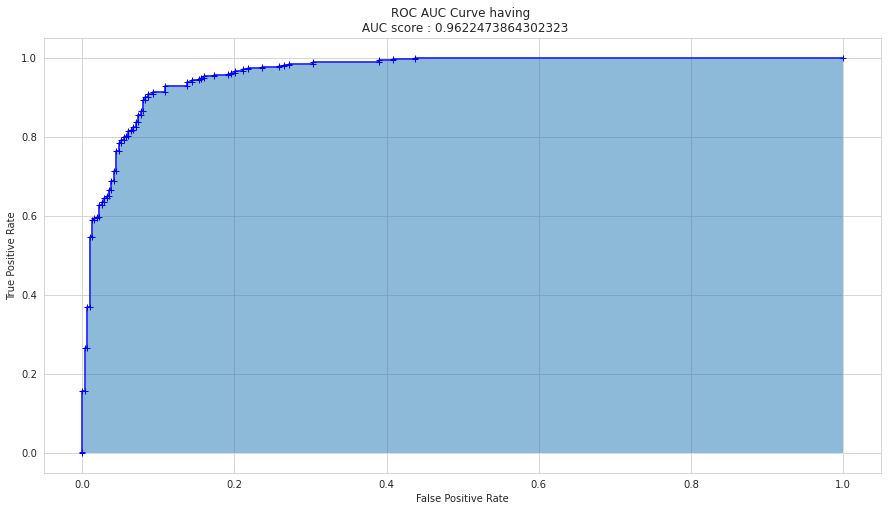

In [103]:
plot_roc_auc_curve(X_std, y_undersampled, clf5)

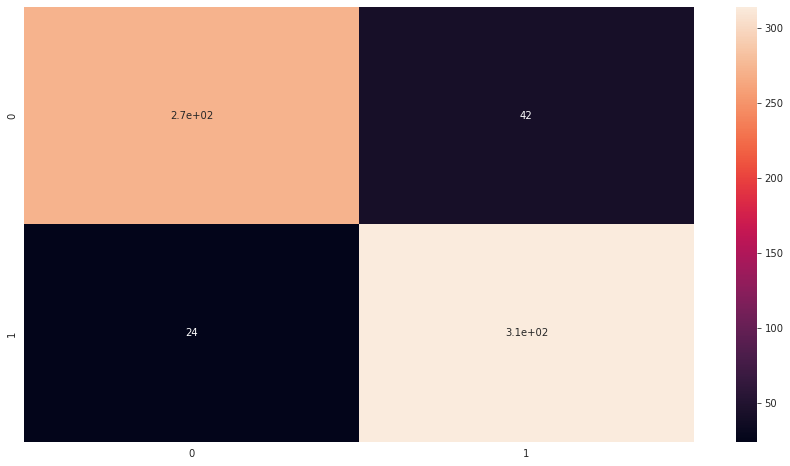

In [104]:
#plot confusion matrix

x_train, x_test, y_train, y_test = train_test_split(X_std, y_undersampled, test_size = 0.2, random_state = 11)

clf5.fit(x_train, y_train)
y_predict = clf5.predict(x_test)

plt.figure(figsize = (15,8))
sns.heatmap(confusion_matrix(y_test, y_predict), annot = True)
plt.show()

In [123]:
models = []  

# Appending models into the list
models.append(
    (
        "LogisticRegression",
        LogisticRegression(random_state=1, class_weight={0: 15, 1: 85}),
    )
)
models.append(
    (
        "DecisionTree",
        DecisionTreeClassifier(random_state=1, class_weight={0: 15, 1: 85}),
        
    )
)
models.append(
(
        "RandomForestTree",
        RandomForestClassifier(random_state=1, class_weight={0: 15, 1: 85}),
)
)
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss"),))
models.append(("Bagging", BaggingClassifier(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X, y=y, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

from sklearn.metrics import recall_score

for name, model in models:
    model.fit(X, y)
    scores = recall_score(y, model.predict(X))
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

LogisticRegression: 89.0
DecisionTree: 92.0
RandomForestTree: 92.0
GBM: 93.0
Adaboost: 92.0
Xgboost: 93.0
Bagging: 87.99999999999999

Validation Performance:

LogisticRegression: 0.92
DecisionTree: 1.0
RandomForestTree: 1.0
GBM: 1.0
Adaboost: 1.0
Xgboost: 1.0
Bagging: 1.0


In [105]:
# example of evaluating a model with random oversampling and undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# define dataset
X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)


# define pipeline
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)


# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)


print('F1 Score: %.3f' % score)

F1 Score: 0.999


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Building a Pipline</h1><a id = "8" ></a>

In [126]:
# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [127]:
# creating a list of numerical variables
numerical_features = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio",
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])


# creating a list of categorical variables
categorical_features = [
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
]

# creating a transformer for categorical variables, which will first apply simple imputer and
# then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),  # handle missing
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# handle_unknown = "ignore", allows model to handle any unknown category in the test data


# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[  # List of (name, transformer, columns)
        ("num_step", numeric_transformer, numerical_features),
        ("cat_step", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
    n_jobs=-1,
    verbose=True,
)

In [128]:
# Creating new pipeline with best parameters
production_model = Pipeline(
    steps=[
        ("pre", preprocessor),  # pipelines from above
        (
            "XGB",  # best model for prediction
            XGBClassifier(
                base_score=0.5,
                booster="gbtree",
                colsample_bylevel=1,
                colsample_bynode=1,
                colsample_bytree=1,
                eval_metric="logloss",
                gamma=0,
                gpu_id=-1,
                importance_type="gain",
                interaction_constraints="",
                learning_rate=0.300000012,
                max_delta_step=0,
                max_depth=6,
                min_child_weight=1,
                missing=np.nan,
                monotone_constraints="()",
                n_estimators=100,
                n_jobs=4,
                num_parallel_tree=1,
                random_state=1,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                subsample=1,
                tree_method="exact",
                validate_parameters=1,
                verbosity=None,
            ),
        ),
    ]
)

In [129]:
# view pipeline
display(production_model[0])
display(type(production_model))

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num_step',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Customer_Age', 'Dependent_count',
                                  'Months_on_book', 'Total_Relationship_Count',
                                  'Months_Inactive_12_mon',
                                  'Contacts_Count_12_mon', 'Credit_Limit',
                                  'Total_Revolving_Bal', 'Avg_Open_To_Buy',
                                  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                                  'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
                                  'Avg_Utilization_Ratio']),
                                ('cat_step',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Education_Level', 'Marital_Status',
                                  'Income_Category', 'Card_Category'])],
                  verbose=True)

sklearn.pipeline.Pipeline

In [134]:
# Fit the model on training data
production_model.fit(X_columns, df.Attrition_Flag.values.ravel())

Pipeline(steps=[('pre',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_step',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Customer_Age',
                                                   'Dependent_count',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Tot...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=4, num_parallel_tree=1,
                               predictor='auto', random_state=1, reg_alpha=0,
                               reg_lambda=1, ...))])

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Conclusion</h1><a id = "9" ></a>

Based on the our model, we clustered the credit card users into the following groups:

Group 1: Higher balance heavy users

Group 2: Long-time very light users

Group 3: Low limit, high balance light users

Group 4: High limit, low balance light users

Group 5: Low limit, low balance light users

Group 6: High limit, low balance heavy users

Looking at the demographic data of each group, we also found the following:

1. Long-time light users are the most likely to turnover
2. Most users are in their 40's and 50's
3. High limit users are mostly male
4. The ratio of married users is higher among Long-time light users
5. High limit users have significantly higher income than other groups, and are more likely to carry premium cards

Through this analysis we have gained a good understanding of the groups that exist within the customers, as well as some of the attributes of each group.

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Key Findings</h1><a id = "9" ></a>

- Using XGBOOST is more effective in predecting churning customers

- Should forcus on factors which has correlation score higher. Total_Relationship_Count,Months_Inactive_12_mon,Contacts_count_12_month, Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct


<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Business Recommendations</h1><a id = "9" ></a>

Company should target customers who attrit based on their historical customer profile from this dataset (as a starting point). These customers should be targeted more by the company and offer them added benefits.:


- We observed in our analysis that the total tranaction count is the #1 feature of importance, followed by the month-to-month balance, then the total amount of products a customer holds with the bank in predicting whether a customer will attrit or not. The company should carefully consider these features and monitor or flag them them for it's customers around the thresholds:


1. total transactions below 100.
2. monthly balance carry-over below 500.
3. total product holdings between 2 - 3.

`TheraBank could offer incentives to customers who fall within ranges of transactions/amounts or resolving balance to incentivize on-going loyalty to the bank.`



<h1 style="text-align: center;" class="list-group-item list-group-item-action active">By Zubair Ahmad</h1><a id = "9" ></a>
<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Buy me a Coffee or Chayee !</h1><a id = "9" ></a>
<h1 style="text-align: center;" class="list-group-item list-group-item-action active">zubairwazir777@gmail.com</h1><a id = "9" ></a>